# Argon simulations
[The promise of disease gene discovery in South Asia](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5675555/)

    These people did a bunch of stuff that seems useful.

* [Argon manuscript](https://academic.oup.com/bioinformatics/article-lookup/doi/10.1093/bioinformatics/btw355)
* [Argon github](https://github.com/pierpal/ARGON)
* [Gravel et al 2011](https://www.pnas.org/content/108/29/11983) which the argon repo provides a config for.

In [1]:
!git clone https://github.com/pierpal/ARGON.git

Cloning into 'ARGON'...
remote: Enumerating objects: 289, done.
remote: Total 289 (delta 0), reused 0 (delta 0), pack-reused 289
Receiving objects: 100% (289/289), 55.45 MiB | 11.15 MiB/s, done.
Resolving deltas: 100% (158/158), done.
Checking connectivity... done.


In [358]:
%matplotlib inline
from __future__ import print_function
from collections import OrderedDict
from IPython.display import display
import matplotlib.pyplot as plt
import glob
import ipyrad.analysis as ipa
import ipyparallel as ipp
import datetime
import itertools
import subprocess
import numpy as np
import pandas as pd
import time
import sys
import os

## Disable annoying pandas warnings.
pd.options.mode.chained_assignment = None

## Python code to generate ARGON models
Here's some simple code to generate ARGON models, allowing for arbitrary population
size histories and arbitrary migration patterns. There are two classes `population` and `model`. 

One __todo__ is to add a `sizechange` function to allow for growth rates, rather than using just fixed values.

Another, probably smarter idea I had was to just parse msprime models into ARGON files directly. Here I'm kind of reimplementing a demographic model construction API, whereas the one for msprime API is perfectly fine, and also probably more robust.

### The population class
Populations are basically named wrappers around a vector of population sizes, 
with one size value per generation. When you create a population you tell it the name, the split time (basically how long it's been around), and optionally the ancestor.

In [357]:
class population(object):
    def __init__(self, name, size, t_split, t_ext=0, anc=''):
        ## name: A short identifier for this population
        ## size: Either an int for constant size since split
        ##       or a list of sizes, which must be == to 
        ##       t_split - t_ext (lifetime of the population)
        ## t_split: When this pop diverged from it's parent
        ## t_ext: Optionally when this population went extinct, default is time zero (present).
        ## anc:  The name of the ancestral population. The first population you add
        ##       to a model is assumed to be the basal lineage, so it has no ancestor.
        self.name = name
        self.anc = anc
        if isinstance(size, int):
            self.sizes = np.array([size] * (t_split - t_ext))
        elif isinstance(size, list):
            if len(size) == (t_split - t_ext):
                self.sizes = size
            else:
                raise Exception("Population size list is of incorrect length")
        self.t_split = t_split
        self.t_ext = t_ext

    def __repr__(self):
        return "{}: t0_size {}, t_split {}".format(self.name, self.sizes[0], self.t_split)

    def to_df(self):
        return pd.DataFrame(self.sizes, columns=[self.name], index=list(range(self.t_ext, self.t_split)))

    ## Bottlenecks need 3 parameters, the time, how long it lasted and the "strength"
    ## The strength can be either an absolute number or a percentage to indicate
    ## relative severity.
    def bottleneck(self, t_bot, duration, N_bot):
        ## t_bot: generations in the past when bottleneck started
        ## duration: # of generations
        ## N_bot: Either an absolute value (int) or a percent
        if t_bot > self.t_split: raise Exception("Bottleneck can't start before pop exists")
        t_end = t_bot - duration
        if t_end < 0: raise Exception("Bottleneck duration can't be larger than start time.")
        if N_bot > 1:
            new_sizes = np.array([N_bot] * duration)
        else:
            new_sizes = self.sizes[t_end:t_bot] * N_bot
        self.sizes = np.concatenate([self.sizes[:t_end], new_sizes, self.sizes[t_bot:]])

## Create a couple populations, apply some bottlenecks, and display the pop size vectors.
afr = population("AFR", 200, 10)
afr.bottleneck(8, 2, .5)
afr.bottleneck(3, 2, .25)
display(afr.to_df())
ceu = population("CEU", [100, 200, 300, 400, 500], t_split=5, anc="AFR")
display(ceu.to_df())

,AFR
0,200.0
1,50.0
2,50.0
3,200.0
4,200.0
5,200.0
6,100.0
7,100.0
8,200.0
9,200.0


,CEU
0,100
1,200
2,300
3,400
4,500


### The model class
The model class encapsulates information about the full demographic history of all populations. Essentially think of it as a pair of DataFrames, one of which holds population size values per population per generation, and one of which contains all information about inter-population migration per generation. The two ways you can manipulate models are to add populations, and to change migration rates.

In [359]:
class model(object):
    def __init__(self, name):
        self.name = name
        self.pop_idxs = OrderedDict({})
        self.pops = OrderedDict({})
        self.migmat = []

    def __repr__(self):
        return "{}: pops {}".format(self.name, self.pop_idxs.keys())

    @property
    def pop_sizes(self):
        return pd.concat([p.to_df() for p in self.pops.values()], axis=1)

    def add_pop(self, pop, verbose=False):
        if len(self.pops) == 0:
            ## You have to add the most basal ancestor lineage first
            ## so this pop won't have an ancestor
            max_age = pop.t_split
            self.migmat = pd.DataFrame(np.ones(max_age), columns=["1_1"],\
                                  index=list(range(max_age)))
            self.pop_idxs[pop.name] = len(self.pop_idxs) + 1
            ## Population sizes
            self.pops[pop.name] = pop

        elif pop.anc not in list(self.pops.keys()):
            raise Exception("Can't add population: Ancestor not in the model {}".format(pop.anc))
        else:
            self.pop_idxs[pop.name] = len(self.pop_idxs) + 1
            ## Population sizes
            self.pops[pop.name] = pop

            ## update the migration matrix
            pidx = self.pop_idxs[pop.name]
            ancidx = self.pop_idxs[pop.anc]
            
            ## Populate a new dataframe with all possible migration directions
            ## among the new pop and all the others, and set all mig fractions to zero
            to_from = ["{}_{}".format(pidx, dest) for dest in self.pop_idxs.values() if not dest == pidx]
            from_to = ["{}_{}".format(dest, pidx) for dest in self.pop_idxs.values() if not dest == pidx]
            mig_list = ["{}_{}".format(dest, dest)] + to_from + from_to
            mig_df = pd.DataFrame(0, columns=mig_list, index=pop.to_df().index)

            ## Set default migration rate for all timepoints _except_ t_split
            ## to have src == dest == pop and mig fraction == 1
            mig_df.loc[:, "{}_{}".format(dest, dest)] = [1] * (len(mig_df)-1) + [0]
            ## set the mass migration back to the ancestor at tdiv
            mig_df.loc[pop.t_split-1, "{}_{}".format(pidx, ancidx)] = 1

            ## Jam the new migration matrix onto the existing one.
            self.migmat = pd.concat([self.migmat, mig_df], axis=1)


    def mig_rate_change(self, src, dest, frac, m_start, m_end=0):
        ## Allow specifying src/dest as names, rather then idxs
        if isinstance(src, str):
            src = self.pop_idxs[src]
        if isinstance(dest, str):
            dest = self.pop_idxs[dest]
        mig_string = "{}_{}".format(src, dest)
        cur_mig = self.migmat[[mig_string]]
        ## If you try to set a migration pulse during a time when one
        ## of the populations doesn't exist then this is bad and it'll raise
        if np.any(cur_mig.loc[m_end:m_start].isna()):
            raise Exception("Attempting to set migration when either src or dest doesn't exist")
        cur_mig.loc[m_end:m_start] = [[frac]] * (m_start - m_end + 1)
        self.migmat[[mig_string]] = cur_mig


    def write_model(self, outfile=''):
        sizes = self.pop_sizes
        with open(outfile, 'w') as out:
            for i in range(len(sizes)):
                ## Write the pop sizes line
                out.write("{}\t{}\n".format(i, "\t".join(map(str, map(int, sizes.loc[i].dropna().values)))))
                ## And now the migration rates
                migline = ["{}_{}".format(k, v) for k, v in self.migmat.loc[i].dropna().iteritems()]
                out.write("\t".join(migline) + "\n")

## Create a toy model
m = model("ooa")
afr = population("AFR", 200, 10)
m.add_pop(afr)
ceu = population("CEU", [100, 200, 300, 400, 500], t_split=5, anc="AFR")
m.add_pop(ceu)
## Demonstrate how to manipulate population sizes after they have been added to the model.
m.pops["AFR"].bottleneck(5, 2, 100)
## You can even add extinct populations
nea = population("NEA", 300, t_split=9, t_ext=3, anc="AFR")
m.add_pop(nea)
## Add some archaic admixture between CEU and NEA
m.mig_rate_change("CEU", "NEA", m_start=3, m_end=3, frac=0.01)
## Look at the internal data representations
display(m.pop_sizes)
display(m.migmat)
## Write the model to a file
m.write_model("/tmp/watdo.mdl")


,AFR,CEU,NEA
0,200,100.0,NaN
1,200,200.0,NaN
2,200,300.0,NaN
3,100,400.0,300.0
4,100,500.0,300.0
5,200,NaN,300.0
6,200,NaN,300.0
7,200,NaN,300.0
8,200,NaN,300.0
9,200,NaN,NaN


,1_1,2_2,2_1,1_2,3_3,3_1,3_2,1_3,2_3
0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.01
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.00
5,1.0,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.00
6,1.0,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.00
7,1.0,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.00
8,1.0,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.00
9,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Load a base model to start with, so you don't have to reinvent the wheel.
It would be convenient to load one of the supplied models (e.g. Gravel 2011) and then build up on this, so you don't have to reinvent the wheel. Right now, the code below only half works. It'll read and parse an ARGON model file into a popsize df and a migmatrix df, but it doesn't yet construct the `model` object from this.

In [332]:
model_file = "ARGON/FILES/DEMOGRAPHIC_MODELS/Gravel_PNAS.txt"
## You need to pass in the pop_idxs, because it's specific to the data being loaded
pop_idxs = {}
for i, pop in enumerate(["AFR", "CEU", "CHB"]):
    ##Argon pops are 1-indexed.
    pop_idxs[pop] = i+1
pops = ["AFR", "CEU", "CHB"]

def fetch_base_model(model_file, pops):
    dat = open(model_file).readlines()
    dat = [l.strip() for l in dat]
    sizes = [map(int, x.split("\t")) for x in dat[0::2]]
    ## The extra call to 'filter' here removes '' caused by having two \t in a row
    mig_rates = [filter(bool, x.split("\t")) for x in dat[1::2]]
    
    ## Format size changes through time to a model df
    size_dict = {x[0]:x[1:] for x in sizes}
    size_df = pd.DataFrame.from_dict(size_dict, orient="index", columns=pops)

    ## Format migration matrix. There's probably a much better way to do this.
    ## You have to account for the fact that argon allows for you to drop the 
    ## trailing `_1` and assume 100% of lineages move from src to dest, and also
    ## because the Gravel argon file appears to allow `1-1` as a synonym for `1_1_1`.
    ## Annoying.
    tmp_mlist = np.array([map(lambda x: x.rsplit("_", 1), y) for y in mig_rates])
    mig_df = pd.DataFrame([], columns=[x[0] for x in tmp_mlist[0]])
    for i, row in enumerate(tmp_mlist):
        #row = np.array(row)
        new_row = []
        for c in row:
            if len(c) == 1:
                new_row.append([c[0].replace("-", "_"), '1'])
            else:
                new_row.append(c)
        row = np.array(new_row)
        try:
            tmp_df = pd.DataFrame([row[:, 1]], columns=row[:, 0], index=[i])
        except:
            print(i, row)
            #raise
        mig_df = pd.concat([mig_df, tmp_df], sort=True)

    return size_df, mig_df

size_df, mig_df = fetch_base_model(model_file, pops)
#mig_rates[2039]
mig_df

,1_1,1_2,1_3,2_1,2_2,2_3,3_1,3_2,3_3
0,0.999967,0.000025,0.000008,0.000025,0.999944,0.000031,0.000008,0.000031,0.999961
1,0.999967,0.000025,0.000008,0.000025,0.999944,0.000031,0.000008,0.000031,0.999961
2,0.999967,0.000025,0.000008,0.000025,0.999944,0.000031,0.000008,0.000031,0.999961
3,0.999967,0.000025,0.000008,0.000025,0.999944,0.000031,0.000008,0.000031,0.999961
4,0.999967,0.000025,0.000008,0.000025,0.999944,0.000031,0.000008,0.000031,0.999961
5,0.999967,0.000025,0.000008,0.000025,0.999944,0.000031,0.000008,0.000031,0.999961
6,0.999967,0.000025,0.000008,0.000025,0.999944,0.000031,0.000008,0.000031,0.999961
7,0.999967,0.000025,0.000008,0.000025,0.999944,0.000031,0.000008,0.000031,0.999961
8,0.999967,0.000025,0.000008,0.000025,0.999944,0.000031,0.000008,0.000031,0.999961
9,0.999967,0.000025,0.000008,0.000025,0.999944,0.000031,0.000008,0.000031,0.999961


# Everything below here is junk/ideas
Patches of code used for building models, parallelization, and plotting. Could be useful to reference.

## Simple code to generate a model using Gravel 2011 as the base
This is very simple code that simulates a founder population(s) model, where _n_ 
populations of size _N_ are randomly sampled from a much larger souce population (here CEU),
and are simultaneously isolated at time _t_, after which they experience some small
fraction of post isolation migration.

In [2]:
def make_model(nl_size = 200, split_gens = 13, npops = 1, migfrac=0, write=True):
    dat = open("ARGON/FILES/DEMOGRAPHIC_MODELS/Gravel_PNAS.txt").readlines()
    dat = [l.strip() for l in dat]
    ## Make the popsizes string
    popstring = "\t" + "\t".join(map(str, [nl_size] * npops))
    ## Make the migration rates string
    popids = range(4, 4+npops)
    migstring = ["{pid}_{pid}_1".format(pid=x) for x in popids]
    migstring += ["{p1}_{p2}_{migfrac}".format(p1=x[0], p2=x[1], migfrac=migfrac) for x in itertools.permutations(popids, 2)]
    migstring = "\t" + "\t".join(migstring)
    for i in range(0, split_gens*2, 2):
        dat[i] = dat[i] + popstring
        dat[i+1] = dat[i+1] + migstring
    dat[split_gens*2] = dat[split_gens*2] + popstring
    dat[split_gens*2+1] = dat[split_gens*2+1] + "\t" + "\t".join("{}_2_1".format(x) for x in popids)
    outfile = "models/{}pop_size{}_split{}_mig{}.mdl".format(npops, nl_size, split_gens, migfrac)
    if write:
        with open(outfile, 'w') as out:
            out.write("\n".join(dat))
    else:
        print(dat[:20])
    return outfile
#mstring = make_model(npops=1, write=False)



### Run models for various population sizes and sample sizes
This is only for reference since it probably won't actually do anything useful rn.

In [207]:
nsamps = 40
npops = 3
migfrac=0
quiet=True
for nbot in [200, 400, 800, 1600]:
    mstring = make_model(nl_size=nbot, split_gens=13, npops=npops, migfrac=migfrac)
    outvcf = mstring.split(".")[0].split("/")[1]
    argon_cmd = "java -jar ARGON/ARGON.0.1.jar -quiet -size 100 -N {} -pop {} 40 40 40 {} -out ./vcfs/{}".\
                format(mstring, npops+3, " ".join(map(str, [nsamps] * npops)), outvcf)
    if not quiet:
        argon_cmd += " -quiet"
    print(argon_cmd)
    !$argon_cmd


java -jar ARGON/ARGON.0.1.jar -quiet -size 100 -N models/3pop_size200_split13_mig0.mdl -pop 6 40 40 40 40 40 40 -out ./vcfs/3pop_size200_split13_mig0 -quiet
Mon Dec 17 19:37:21 EST 2018

ARGON version 0.1.160415 (April 15, 2016; Pier Palamara, ppalama AT hsph DOT harvard DOT edu)

Starting simulation. Parameters:

Parameter values:
	-N		Population size is models/3pop_size200_split13_mig0.mdl.
	-pop		There will be 6 population(s).
			Population 1 will have 40 samples.
			Population 2 will have 40 samples.
			Population 3 will have 40 samples.
			Population 4 will have 40 samples.
			Population 5 will have 40 samples.
			Population 6 will have 40 samples.
	-len		Minimum block size is 1 microMorgans.
	-size		Will simulate a chromosome of length 100.0 cM and 100.0 Mb.
	-rec		Recombination rate per base pair is 1.0E-8.
	-mut		Mutation rate per base pair is 1.65E-8.
	-map		Map file not specified.
	-seed		Random seed is 1545093441363.
	-GC		Non-crossover gene conversion (NCOGC) is not active.

KeyboardInterrupt: 

# Parallelization routines

In [3]:
## Wrap calls to a command for ipcluster engines
def call_proc(cmd):
    import subprocess
    import os
    os.chdir("/home/isaac/SequenceBio-NL/analysis/argon")
    ret = subprocess.check_output(cmd.split())
    return ret

## Progress bar utility func
def progressbar(njobs, finished, msg="", spacer="  "):
    """ prints a progress bar """
    if njobs:
        progress = 100*(finished / float(njobs))
    else:
        progress = 100

    hashes = '#'*int(progress/5.)
    nohash = ' '*int(20-len(hashes))

    args = [spacer, hashes+nohash, int(progress), msg]
    print("\r{}[{}] {:>3}% {} ".format(*args), end = "")
    sys.stdout.flush()
progressbar(100, 50)

## Pass in a list of commands you want to run in parallel and it'll run them
## and track progress
def wrap_ipclust(cmd_list):
    
    ipclient = ipp.Client(cluster_id="seqbio")
    print("ncores {}".format(len(ipclient)))
    lbview = ipclient.load_balanced_view()
    
    asyncs = []
    for cmd in cmd_list:
        asyncs.append(lbview.apply_async(call_proc, cmd))

    printstr = ' Processing         | {} |'

    jobs = len(asyncs)
    start = time.time()
    while 1:
        ready = [i.ready() for i in asyncs]
        elapsed = datetime.timedelta(seconds=int(time.time()-start))
        progressbar(jobs, sum(ready), printstr.format(elapsed))
        time.sleep(1)
        if all(ready):
            print("")
            break

    for async in asyncs:
        print(async.result())
cmd_list = ["ls", "ls /", "ls /tmp"]
wrap_ipclust(cmd_list)

  [##########          ]  50%  ncores 12
  [####################] 100%  Processing         | 0:00:01 | 
ARGON
ARGON.map
ARGON.vcf
Gravel_PNAS.txt
ipyrad_log.txt
large_vcfs
mod1.txt
models
out.log
out.LROH
pops
SeqBio-Argon_sims.ipynb
sqbio-WF-sims.ipynb
stats
vcfs

bin
boot
cdrom
core
dev
etc
home
initrd.img
initrd.img.old
lib
lib32
lib64
lost+found
media
mnt
opt
proc
root
run
sbin
snap
srv
sys
tmp
usr
var
vmlinuz
vmlinuz.old

analysis-bucky
analysis-structure
chr11_10pop_size200_split13_mig0.001.vcf.log
config-err-67Klfu
config-err-bJ1nxk
damien
file436cNB
file52H9fj
fileDSa6oS
fileqWeYEI
fileRHPy6M
filerKmnOu
fileWuqoU3
fileZVYQnI
firefox_laura
gnome-software-02IPRZ
gnome-software-0AY0RZ
gnome-software-0FBDRZ
gnome-software-0L23RZ
gnome-software-0M3DRZ
gnome-software-0YDVQZ
gnome-software-162NVZ
gnome-software-18GORZ
gnome-software-1RMQUZ
gnome-software-1XI0SZ
gnome-software-2UCETZ
gnome-software-2ZCDRZ
gnome-software-35TTUZ
gnome-software-3968TZ
gnome-software-3EUDUZ
gnome-software-

In [219]:
## Parallel version
nsamps = 40
npops = 10
migfrac=0
quiet=True

cmds = []
for nbot in [200, 400, 800, 1600]:
    for mig in [0, 0.001, 0.01]:
        mstring = make_model(nl_size=nbot, split_gens=13, npops=npops, migfrac=mig)
        outvcf = mstring.rsplit(".", 1)[0].split("/")[1]
        argon_cmd = "java -jar ARGON/ARGON.0.1.jar -quiet -size 100 -N {} -pop {} 40 40 40 {} -out ./vcfs/{}".\
                    format(mstring, npops+3, " ".join(map(str, [nsamps] * npops)), outvcf)
        if not quiet:
            argon_cmd += " -quiet"
        print(argon_cmd)
        cmds.append(argon_cmd)

wrap_ipclust(cmds)

java -jar ARGON/ARGON.0.1.jar -quiet -size 100 -N models/10pop_size200_split13_mig0.mdl -pop 13 40 40 40 40 40 40 40 40 40 40 40 40 40 -out ./vcfs/10pop_size200_split13_mig0
java -jar ARGON/ARGON.0.1.jar -quiet -size 100 -N models/10pop_size200_split13_mig0.001.mdl -pop 13 40 40 40 40 40 40 40 40 40 40 40 40 40 -out ./vcfs/10pop_size200_split13_mig0.001
java -jar ARGON/ARGON.0.1.jar -quiet -size 100 -N models/10pop_size200_split13_mig0.01.mdl -pop 13 40 40 40 40 40 40 40 40 40 40 40 40 40 -out ./vcfs/10pop_size200_split13_mig0.01
java -jar ARGON/ARGON.0.1.jar -quiet -size 100 -N models/10pop_size400_split13_mig0.mdl -pop 13 40 40 40 40 40 40 40 40 40 40 40 40 40 -out ./vcfs/10pop_size400_split13_mig0
java -jar ARGON/ARGON.0.1.jar -quiet -size 100 -N models/10pop_size400_split13_mig0.001.mdl -pop 13 40 40 40 40 40 40 40 40 40 40 40 40 40 -out ./vcfs/10pop_size400_split13_mig0.001
java -jar ARGON/ARGON.0.1.jar -quiet -size 100 -N models/10pop_size400_split13_mig0.01.mdl -pop 13 40 40 40 

In [229]:
## Gravel 
pca = ipa.pca("vcfs/10pop_size1600_split13_mig0.001.vcf")
samps = pca.samples_vcforder
pops_dict = {
    #"AFR":samps[:20],
    "CEU":samps[20:40],
    "CHB":samps[40:60],
    "NL1":samps[60:80],
    "NL2":samps[80:100],
    "NL3":samps[100:120],
    "NL4":samps[120:140],
    "NL5":samps[140:160],
    "NL6":samps[160:180],
    "NL7":samps[180:200],
    "NL8":samps[200:220],
    "NL9":samps[220:240],
    "NL10":samps[240:]
}
## Don't do this, because it's ugly
#for f in glob.glob("./vcfs/*.vcf"):
#    pca = ipa.pca(f, pops=pops_dict)
#    ax = pca.plot()
#    ax.set_title("{}".format(f.split("/")[-1].rsplit(".", 1)[0]))

In [230]:
print(pops_dict)

{'NL1': array([u'4_1', u'4_2', u'4_3', u'4_4', u'4_5', u'4_6', u'4_7', u'4_8',
       u'4_9', u'4_10', u'4_11', u'4_12', u'4_13', u'4_14', u'4_15',
       u'4_16', u'4_17', u'4_18', u'4_19', u'4_20'], dtype=object), 'NL3': array([u'6_1', u'6_2', u'6_3', u'6_4', u'6_5', u'6_6', u'6_7', u'6_8',
       u'6_9', u'6_10', u'6_11', u'6_12', u'6_13', u'6_14', u'6_15',
       u'6_16', u'6_17', u'6_18', u'6_19', u'6_20'], dtype=object), 'NL2': array([u'5_1', u'5_2', u'5_3', u'5_4', u'5_5', u'5_6', u'5_7', u'5_8',
       u'5_9', u'5_10', u'5_11', u'5_12', u'5_13', u'5_14', u'5_15',
       u'5_16', u'5_17', u'5_18', u'5_19', u'5_20'], dtype=object), 'NL5': array([u'8_1', u'8_2', u'8_3', u'8_4', u'8_5', u'8_6', u'8_7', u'8_8',
       u'8_9', u'8_10', u'8_11', u'8_12', u'8_13', u'8_14', u'8_15',
       u'8_16', u'8_17', u'8_18', u'8_19', u'8_20'], dtype=object), 'NL4': array([u'7_1', u'7_2', u'7_3', u'7_4', u'7_5', u'7_6', u'7_7', u'7_8',
       u'7_9', u'7_10', u'7_11', u'7_12', u'7_13', u'7_14', u

Doing vcfs/10pop_size200_split13_mig0.vcf
Doing vcfs/10pop_size200_split13_mig0.001.vcf
Doing vcfs/10pop_size200_split13_mig0.01.vcf
Doing vcfs/10pop_size400_split13_mig0.vcf
Doing vcfs/10pop_size400_split13_mig0.001.vcf
Doing vcfs/10pop_size400_split13_mig0.01.vcf
Doing vcfs/10pop_size800_split13_mig0.vcf
Doing vcfs/10pop_size800_split13_mig0.001.vcf
Doing vcfs/10pop_size800_split13_mig0.01.vcf


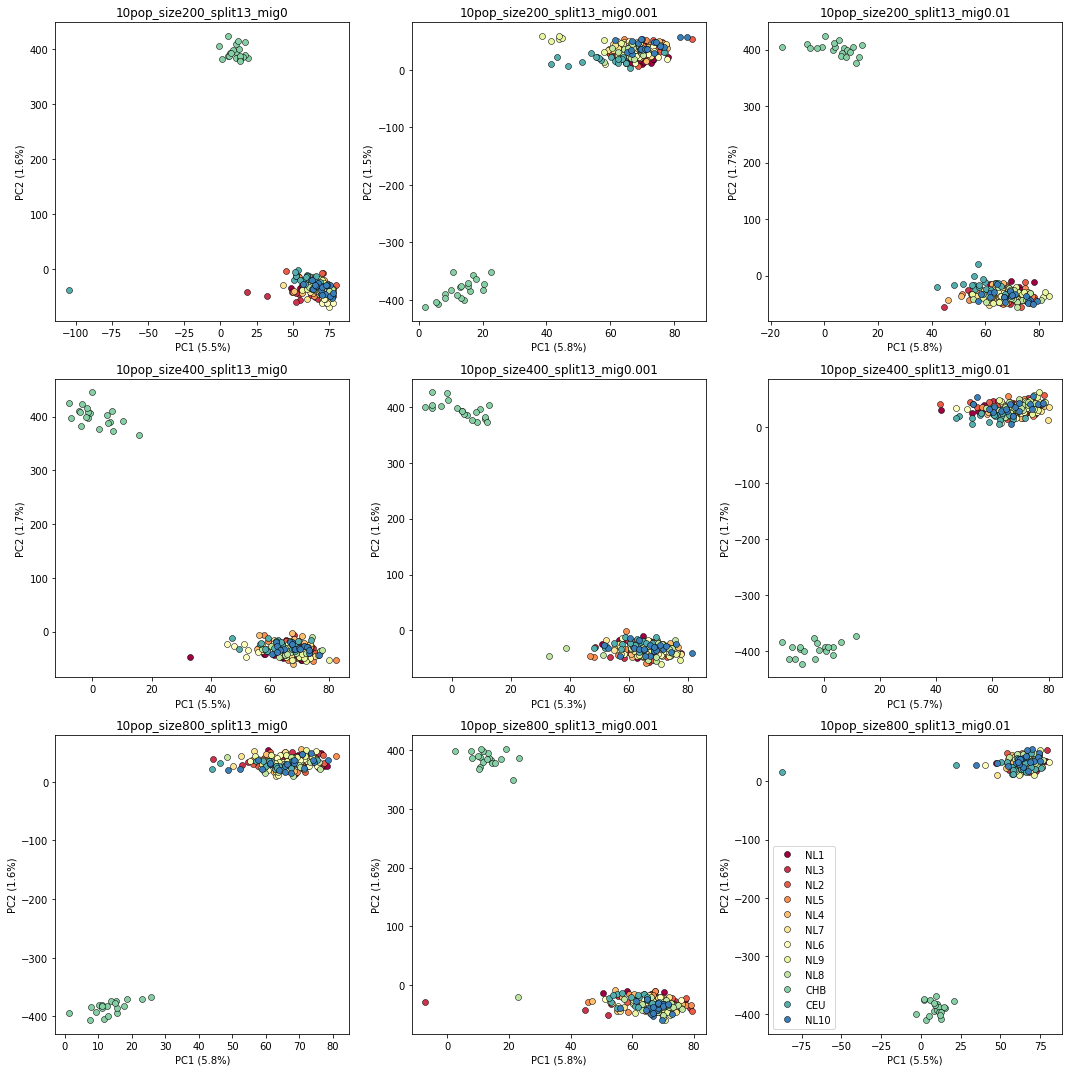

In [231]:
## Prettier layout
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = [x for y in axs for x in y]
idx = 0
for nbot in [200, 400, 800]:
    for mig in [0, 0.001, 0.01]:
        f = glob.glob("vcfs/10pop*{}*{}.vcf".format(nbot, mig))[0]
        print("Doing", f)
        pca = ipa.pca(f, pops=pops_dict)
        ax = pca.plot(ax=axs[idx], legend=False)
        ax.set_title("{}".format(f.split("/")[-1].rsplit(".", 1)[0]))
        
        idx += 1
axs[idx-1].legend()
plt.tight_layout()

In [258]:
## counts2
## relatedness2
## het
## relatedness - Useless
## LROH --chr1 - Requires chromosome, and the simulated chrom is always 1
## site-pi
def calc_vcfstat(statname, vcffile="vcfs/10pop_size400_split13_mig0.001.vcf"):
    cmds = []
    for pop in pops_dict:
        f = "pops/{}.txt".format(pop)
        with open(f, 'w') as outfile:
            outfile.write("\n".join(map(str, [x for x in pops_dict[pop]])))
        cmd = "/home/isaac/miniconda2/envs/ipyrad/bin/vcftools --{} --vcf {} --out stats/{} --keep {}".format(\
                                                                                    statname, vcffile, pop, f)
        cmds.append(cmd)
    wrap_ipclust(cmds)
calc_vcfstat("site-pi")

ncores 12
  [####################] 100%  Processing         | 0:03:27 | 














In [93]:
!/home/isaac/miniconda2/envs/ipyrad/bin/vcftools --LROH --vcf vcfs/3pop_size400_split13_mig0.01.vcf --out stats/NL1 --keep pops/NL1.txt



Error: Require a chromosome (--chr) when outputting LROH.



# SFS from allele counts

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40.]


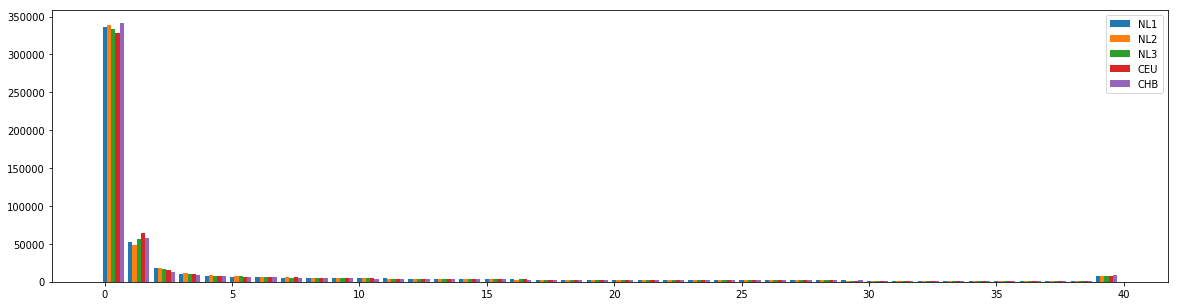

In [36]:
import numpy as np

fig, ax = plt.subplots(figsize=(20, 5))
df1 = pd.read_csv("stats/NL1.frq.count", sep="\t", skiprows=0)
df2 = pd.read_csv("stats/NL2.frq.count", sep="\t", skiprows=0)
df3 = pd.read_csv("stats/NL3.frq.count", sep="\t", skiprows=0)
dfceu = pd.read_csv("stats/CEU.frq.count", sep="\t", skiprows=0)
dfchb = pd.read_csv("stats/CHB.frq.count", sep="\t", skiprows=0)

width = 1/6.

bar1, bins1 = np.histogram(df1.iloc[:, -1:].values, bins=40)
bar2, bins2 = np.histogram(df2.iloc[:, -1:].values, bins=40)
bar3, bins3 = np.histogram(df3.iloc[:, -1:].values, bins=40)
barceu, binsceu = np.histogram(dfceu.iloc[:, -1:].values, bins=40)
barchb, binschb = np.histogram(dfchb.iloc[:, -1:].values, bins=40)

ax.bar(bins1[:-1], bar1, width=width, label="NL1")
ax.bar(bins2[:-1]+width, bar2, width=width, label="NL2")
ax.bar(bins3[:-1]+width*2, bar3, width=width, label="NL3")
ax.bar(binsceu[:-1]+width*3, barceu, width=width, label="CEU")
ax.bar(binschb[:-1]+width*4, barchb, width=width, label="CHB")
ax.legend()
print(bins1)

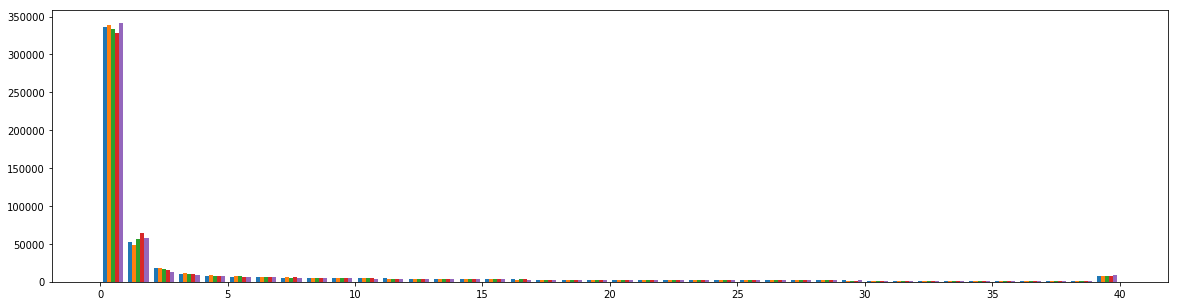

In [47]:
x = [df1.iloc[:, -1:].values.flatten(), df2.iloc[:, -1:].values.flatten(), df3.iloc[:, -1:].values.flatten(),\
     dfceu.iloc[:, -1:].values.flatten(), dfchb.iloc[:, -1:].values.flatten()]
fig, ax = plt.subplots(figsize=(20, 5))
_, _, _ = ax.hist(x, 40)

# Various flavors of relatedness

In [89]:
## Inbreeding the way Zhai et al caclulate it
for f in glob.glob("stats/*.het"):
    print(f)
    df = pd.read_csv(f, sep="\t", header=0)
    df["F"].mean()
    print((df["E(HOM)"].mean() - df["O(HOM)"].mean())/df["E(HOM)"].mean())

print()
for f in glob.glob("stats/*.relatedness2"):
    print(f)
    df = pd.read_csv(f, sep="\t", header=0)
    df_rel = df[df["RELATEDNESS_PHI"] < 0.5]
    print(df_rel["RELATEDNESS_PHI"].mean())

print()
for f in glob.glob("stats/*.relatedness"):
    print(f)
    df = pd.read_csv(f, sep="\t", header=0)
    df_rel = df[df["RELATEDNESS_AJK"] < 0.9]
    print(df_rel["RELATEDNESS_AJK"].mean())



stats/NL2.het
0.006545483312250691
stats/CEU.het
-0.0006044581996937505
stats/NL3.het
0.0021002748803877207
stats/CHB.het
-0.0006938181062754875
stats/NL1.het
-0.005279441110189665

stats/CHB.relatedness2
-0.002448872475263158
stats/NL3.relatedness2
0.0035404390578947353
stats/CEU.relatedness2
-0.0022291021957894738
stats/NL1.relatedness2
-0.019155389589473687
stats/NL2.relatedness2
0.01952619137894737

stats/NL3.relatedness
-0.051127281857894745
stats/CHB.relatedness
-0.05135078894736843
stats/CEU.relatedness
-0.05137809947368421
stats/NL2.relatedness
-0.05047042015263158
stats/NL1.relatedness
-0.052002376363157896


# Pi

stats/CHB.sites.pi
0.0676243246751159
stats/NL8.sites.pi
0.0694934064542504
stats/NL7.sites.pi
0.06944487532457497
stats/NL6.sites.pi
0.06878347638608963
stats/NL10.sites.pi
0.06892039629474496
stats/NL5.sites.pi
0.06984725782163832
stats/CEU.sites.pi
0.07106073497171561
stats/NL3.sites.pi
0.06979962783462132
stats/NL2.sites.pi
0.0692535536969088
stats/NL4.sites.pi
0.06879945899551779
stats/NL1.sites.pi
0.06963541655270478
stats/NL9.sites.pi
0.06900826670772797


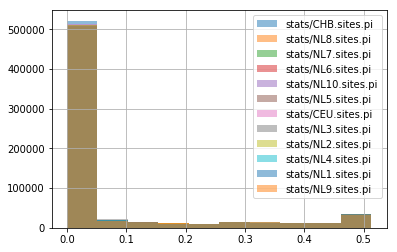

In [234]:
for f in glob.glob("stats/*.sites.pi"):
    print(f)
    df_pis = pd.read_csv(f, sep="\t", header=0)
    print(df_pis["PI"].mean())
    ax = df_pis["PI"].hist(alpha=0.5, label=f)
ax.legend()

stats/NL8.sites.pi
stats/NL7.sites.pi
stats/NL6.sites.pi
stats/NL10.sites.pi
stats/NL5.sites.pi
stats/NL3.sites.pi
stats/NL2.sites.pi
stats/NL4.sites.pi
stats/NL1.sites.pi
stats/NL9.sites.pi
stats/CHB.sites.pi


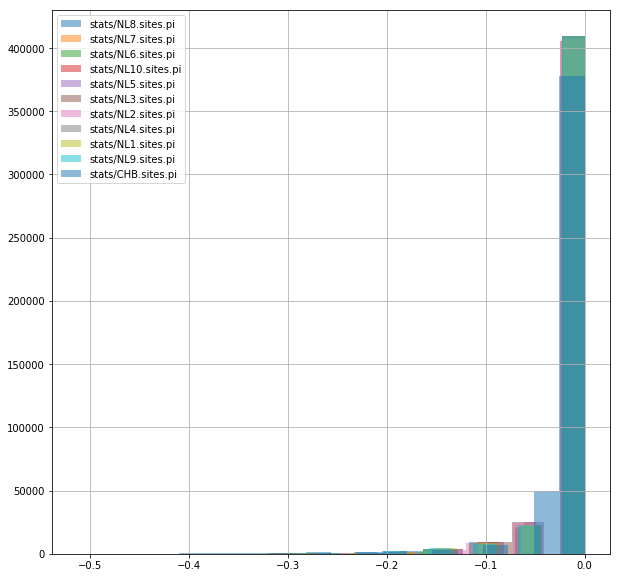

In [235]:
df_ceu = pd.read_csv("stats/CEU.sites.pi", sep="\t", header=0)
for f in glob.glob("stats/NL*.sites.pi") + ["stats/CHB.sites.pi"]:
    print(f)
    df_nlpi = pd.read_csv(f, sep="\t", header=0)
    low_fq = df_ceu["PI"] < 0.01
    diff = df_ceu["PI"][low_fq] - df_nlpi["PI"][low_fq]
#    diff = df_nlpi["PI"][low_fq] - df_ceu["PI"][low_fq]
    diff = diff[diff < 0.01]
    ax = diff.hist(bins=20, alpha=0.5, label=f, density=False, figsize=(10, 10))
ax.legend()

/home/isaac/SequenceBio-NL/analysis/argon


## Generate much larger sample sizes

In [486]:
!pwd

/home/isaac/SequenceBio-NL/analysis/argon


In [ ]:
## Parallel version
nsamps = 200
npops = 10
migfrac=0.001
quiet=True
outdir = "/media/4TB/isaac/seqbio/wgs_sims/vcfs"

cmds = []
for nbot in [200]:
    for chrom in range(22):
        mstring = make_model(nl_size=nbot, split_gens=13, npops=npops, migfrac=migfrac)
        outvcf = "chr{}_".format(chrom) + mstring.rsplit(".", 1)[0].split("/")[1]
        ## Order of pops is AFR CEU CHB. Don't fuck it up.
        argon_cmd = "java -jar ARGON/ARGON.0.1.jar -quiet -size 100 -N {} -pop {} 200 10000 200 {} -out {}/{}".\
                    format(mstring, npops+3, " ".join(map(str, [nsamps] * npops)), outdir, outvcf)
        if not quiet:
            argon_cmd += " -quiet"
        print(argon_cmd)
        cmds.append(argon_cmd)

wrap_ipclust(cmds)

java -jar ARGON/ARGON.0.1.jar -quiet -size 100 -N models/10pop_size200_split13_mig0.001.mdl -pop 13 200 10000 200 200 200 200 200 200 200 200 200 200 200 -out /media/4TB/isaac/seqbio/wgs_sims/vcfs/chr0_10pop_size200_split13_mig0.001
java -jar ARGON/ARGON.0.1.jar -quiet -size 100 -N models/10pop_size200_split13_mig0.001.mdl -pop 13 200 10000 200 200 200 200 200 200 200 200 200 200 200 -out /media/4TB/isaac/seqbio/wgs_sims/vcfs/chr1_10pop_size200_split13_mig0.001
java -jar ARGON/ARGON.0.1.jar -quiet -size 100 -N models/10pop_size200_split13_mig0.001.mdl -pop 13 200 10000 200 200 200 200 200 200 200 200 200 200 200 -out /media/4TB/isaac/seqbio/wgs_sims/vcfs/chr2_10pop_size200_split13_mig0.001
java -jar ARGON/ARGON.0.1.jar -quiet -size 100 -N models/10pop_size200_split13_mig0.001.mdl -pop 13 200 10000 200 200 200 200 200 200 200 200 200 200 200 -out /media/4TB/isaac/seqbio/wgs_sims/vcfs/chr3_10pop_size200_split13_mig0.001
java -jar ARGON/ARGON.0.1.jar -quiet -size 100 -N models/10pop_size2

In [4]:
with open("/media/4TB/isaac/seqbio/wgs_sims/vcfs/chr0_10pop_size200_split13_mig0.001.vcf") as inf:
    l = inf.readline()
    while "#CHROM" not in l:
        l = inf.readline()
## SPlit and drop everything that isn't a sample name
samps = l.split()[9:]
#print(l)
pops_dict = {
    #"AFR":samps[:20],
    "CEU":[x for x in samps if x.startswith("2_")],
    "CHB":[x for x in samps if x.startswith("3_")],
    "NL1":[x for x in samps if x.startswith("4_")],
    "NL2":[x for x in samps if x.startswith("5_")],
    "NL3":[x for x in samps if x.startswith("6_")],
    "NL4":[x for x in samps if x.startswith("7_")],
    "NL5":[x for x in samps if x.startswith("8_")],
    "NL6":[x for x in samps if x.startswith("9_")],
    "NL7":[x for x in samps if x.startswith("10_")],
    "NL8":[x for x in samps if x.startswith("11_")],
    "NL9":[x for x in samps if x.startswith("12_")],
    "NL10":[x for x in samps if x.startswith("13_")]
}
## Can't believe this worked the first time
pops_dict["NL_All"] = [x for k,v in pops_dict.items() for x in v if "NL" in k]
pops_dict


{'CEU': ['2_1',
  '2_2',
  '2_3',
  '2_4',
  '2_5',
  '2_6',
  '2_7',
  '2_8',
  '2_9',
  '2_10',
  '2_11',
  '2_12',
  '2_13',
  '2_14',
  '2_15',
  '2_16',
  '2_17',
  '2_18',
  '2_19',
  '2_20',
  '2_21',
  '2_22',
  '2_23',
  '2_24',
  '2_25',
  '2_26',
  '2_27',
  '2_28',
  '2_29',
  '2_30',
  '2_31',
  '2_32',
  '2_33',
  '2_34',
  '2_35',
  '2_36',
  '2_37',
  '2_38',
  '2_39',
  '2_40',
  '2_41',
  '2_42',
  '2_43',
  '2_44',
  '2_45',
  '2_46',
  '2_47',
  '2_48',
  '2_49',
  '2_50',
  '2_51',
  '2_52',
  '2_53',
  '2_54',
  '2_55',
  '2_56',
  '2_57',
  '2_58',
  '2_59',
  '2_60',
  '2_61',
  '2_62',
  '2_63',
  '2_64',
  '2_65',
  '2_66',
  '2_67',
  '2_68',
  '2_69',
  '2_70',
  '2_71',
  '2_72',
  '2_73',
  '2_74',
  '2_75',
  '2_76',
  '2_77',
  '2_78',
  '2_79',
  '2_80',
  '2_81',
  '2_82',
  '2_83',
  '2_84',
  '2_85',
  '2_86',
  '2_87',
  '2_88',
  '2_89',
  '2_90',
  '2_91',
  '2_92',
  '2_93',
  '2_94',
  '2_95',
  '2_96',
  '2_97',
  '2_98',
  '2_99',
  '2_100',
 

In [7]:
vcfbin = "/home/isaac/miniconda2/envs/ipyrad/bin/vcftools"
prefix = "/media/4TB/isaac/seqbio/wgs_sims/"
vcfdir = prefix + "vcfs"
statdir = prefix + "stats"

In [ ]:
## counts2
## relatedness2
## het
## relatedness - Useless
## LROH --chr1 - Requires chromosome, and the simulated chrom is always 1
## site-pi
## freq

def calc_vcfstat(statname, pops_dict, vcffiles):
    cmds = []
    for vcf in vcffiles:
        chrom = vcf.split("/")[-1].split("_")[0]
        for pop in ["CEU", "NL_All"]:
            f = "{}pops/{}.txt".format(prefix, pop)
            with open(f, 'w') as outfile:
                outfile.write("\n".join(map(str, [x for x in pops_dict[pop]])))
            cmd = "{} --{} --vcf {} --out {}/{}_{} --keep {}".format(\
                                                            vcfbin, statname, vcf, statdir, chrom, pop, f)
            print(cmd)
            cmds.append(cmd)
    wrap_ipclust(cmds)
calc_vcfstat("freq", pops_dict=pops_dict, vcffiles=glob.glob("{}/*.vcf".format(vcfdir)))

In [5]:
import numpy as np

subset_pops_dict = {}
subset_pops_dict["NL_All"] = np.random.choice(pops_dict["NL_All"], 50)
subset_pops_dict["CEU"] = np.random.choice(pops_dict["CEU"], 50)
subset_pops_dict
for k, v in subset_pops_dict.items():
    with open("/tmp/tmp_pop.txt", 'a') as outfile:
        outfile.write("\n".join(v))

Doing 0
/home/isaac/miniconda2/envs/ipyrad/bin/vcftools --vcf /media/4TB/isaac/seqbio/wgs_sims/vcfs/chr0_10pop_size200_split13_mig0.001.vcf --out /tmp/chr0_10pop_size200_split13_mig0.001.vcf --recode --keep /tmp/tmp_pop.txt
Doing 1
/home/isaac/miniconda2/envs/ipyrad/bin/vcftools --vcf /media/4TB/isaac/seqbio/wgs_sims/vcfs/chr1_10pop_size200_split13_mig0.001.vcf --out /tmp/chr1_10pop_size200_split13_mig0.001.vcf --recode --keep /tmp/tmp_pop.txt
Doing 2
/home/isaac/miniconda2/envs/ipyrad/bin/vcftools --vcf /media/4TB/isaac/seqbio/wgs_sims/vcfs/chr2_10pop_size200_split13_mig0.001.vcf --out /tmp/chr2_10pop_size200_split13_mig0.001.vcf --recode --keep /tmp/tmp_pop.txt
Doing 3
/home/isaac/miniconda2/envs/ipyrad/bin/vcftools --vcf /media/4TB/isaac/seqbio/wgs_sims/vcfs/chr3_10pop_size200_split13_mig0.001.vcf --out /tmp/chr3_10pop_size200_split13_mig0.001.vcf --recode --keep /tmp/tmp_pop.txt
Doing 4
/home/isaac/miniconda2/envs/ipyrad/bin/vcftools --vcf /media/4TB/isaac/seqbio/wgs_sims/vcfs/chr4

KeyboardInterrupt: 

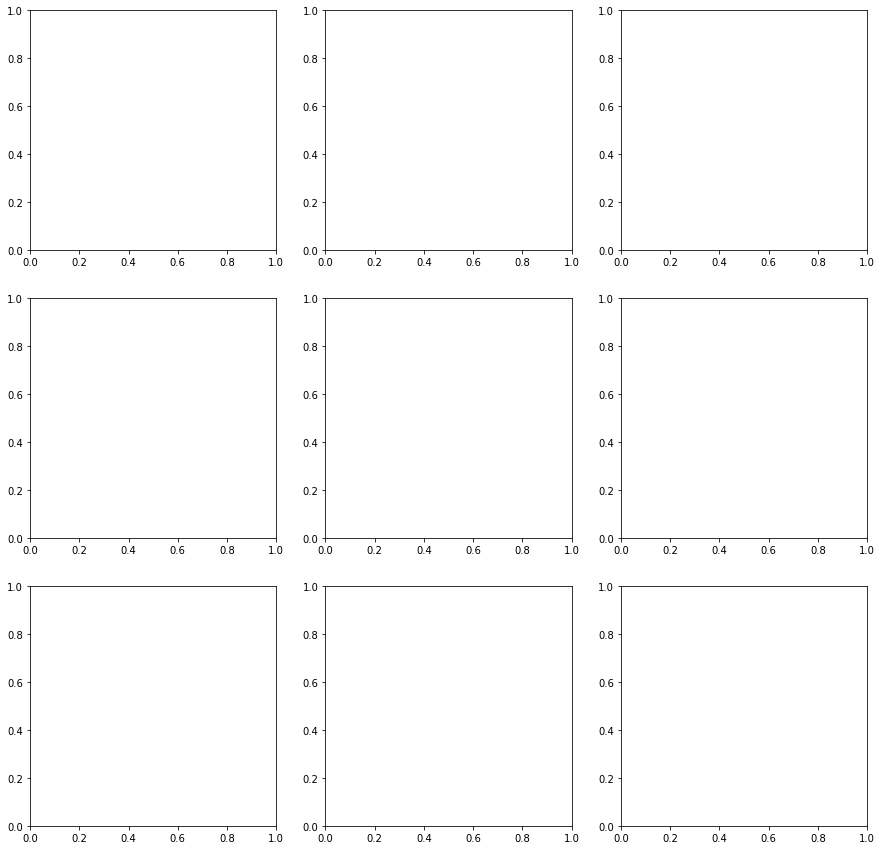

In [8]:
## Prettier layout
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = [x for y in axs for x in y]
idx = 0
cmds = []
for f in range(12):
    vcf = "/media/4TB/isaac/seqbio/wgs_sims/vcfs/chr{}_10pop_size200_split13_mig0.001.vcf".format(f)
    cmd = "{} --vcf {} --out /tmp/{} --recode --keep /tmp/tmp_pop.txt".format(\
                                                            vcfbin, vcf, vcf.split("/")[-1])
    print("Doing", f)
    print(cmd)
    cmds.append(cmd)
wrap_ipclust(cmds)
#    pca = ipa.pca(f, pops=subset_pops_dict)
#    ax = pca.plot(ax=axs[idx], legend=False)
#    ax.set_title("{}".format(f.split("/")[-1].rsplit(".", 1)[0]))

#    idx += 1
#axs[idx-1].legend()
#plt.tight_layout()

### Additionally run these commands to get site pi for all NL pops combined
vcftools --site-pi --vcf 10pop_size200_split13_mig0.vcf --out stats/nomig --keep pops/NL_All.txt  
vcftools --site-pi --vcf 10pop_size200_split13_mig0.001.vcf --out stats/lowmig --keep pops/NL_All.txt

# THiS is foR PIIIII

In [ ]:
## Read in the site pis
NL_df = pd.read_csv("stats_NL_combined/NL_All_0.sites.pi", sep="\t", header=0)
CEU_df = pd.read_csv("stats_0/CEU.sites.pi", sep="\t", header=0)
CHB_df = pd.read_csv("stats_0/CHB.sites.pi", sep="\t", header=0)
print(len(NL_df), len(CEU_df))

In [ ]:
min_fq = 0.001

fig, ax = plt.subplots(figsize=(10, 5))
for mig in ["0", "0.001"]:
    NL_df = pd.read_csv("stats_NL_combined/NL_All_{}.sites.pi".format(mig), sep="\t", header=0)
    CEU_df = pd.read_csv("stats_{}/CEU.sites.pi".format(mig), sep="\t", header=0)

    ## Only look at sites that are low fq in CEU, and that are present in both pops
    low_fq_mask = (CEU_df.PI <= min_fq) & (CEU_df.PI > 0) & (NL_df.PI > (10*min_fq))
    print(np.sum(low_fq_mask))
    ax.hist(NL_df.PI[low_fq_mask] - CEU_df.PI[low_fq_mask], bins=50, label=mig, alpha=0.7, range=(0.01, 0.06))
plt.legend(title="Exogamy Rate")


In [ ]:
min_fq = 0.001

fig, ax = plt.subplots(figsize=(10, 5))
CEU_df = pd.read_csv("stats_0.001/CEU.sites.pi".format(mig), sep="\t", header=0)

for pop in range(3, 6):
    NL_df = pd.read_csv("stats_0.001/NL{}.sites.pi".format(pop), sep="\t", header=0)
    ## Only look at sites that are low fq in CEU, and that are present in both pops
    low_fq_mask = (CEU_df.PI <= min_fq) & (CEU_df.PI > 0) & (NL_df.PI > (min_fq))
    print(np.sum(low_fq_mask))
    ax.hist(NL_df.PI[low_fq_mask] - CEU_df.PI[low_fq_mask], bins=20, label="NL{}".format(pop), alpha=0.7, range=(0.01, 0.4))
plt.legend(title="NL pop")


# This is for frequency

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

## Read in the site pis
min_fq = 0.0001
fig, ax = plt.subplots(figsize=(10, 5))

NL_df = pd.read_csv("ultra_sims/stats/stats_NL_combined/NL_All_0.001.frq", sep="\t")
NL_df.columns = ["POS","N_ALLELES", "N_CHR", "A1", "A2"]
CEU_df = pd.read_csv("ultra_sims/stats/stats_0.001/CEU.frq", sep="\t", header=0)
CEU_df.columns = ["POS","N_ALLELES", "N_CHR", "A1", "A2"]
print(len(NL_df), len(CEU_df))
def get_fqs(df, allel):
    fqs = pd.DataFrame(df[allel].apply(lambda x: x.split(":")[1]), dtype=np.float64)
    return fqs

NL_fq = get_fqs(NL_df, "A1")
CEU_fq = get_fqs(CEU_df, "A1")

low_fq_mask = (CEU_fq.A1 <= min_fq) & (CEU_fq.A1 > 0) & (NL_fq.A1 > 0)
hi_fq_mask = (1- CEU_fq.A1 <= min_fq) & (1 - CEU_fq.A1 > 0) & (1 - NL_fq.A1 > 0)
print(np.sum(low_fq_mask), np.sum(hi_fq_mask))
fq_mask = low_fq_mask | hi_fq_mask
ax.hist(abs(NL_fq.A1[fq_mask] - CEU_fq.A1[fq_mask]), bins=40, label=mig, alpha=0.7, range=(0.01, 0.05))
plt.legend(title="Exogamy Rate")

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

col_headers =  ["POS","N_ALLELES", "N_CHR", "A1", "A2"]

## Subfunc to get fqs from df
def get_fqs(df, allel):
    fqs = pd.DataFrame(df[allel].apply(lambda x: x.split(":")[1]), dtype=np.float64)
    return fqs

def fq_enrichment(CEU_fq_file, NL_fq_file):
    
    CEU_df = pd.read_csv(CEU_fq_file, sep="\t", header=0)
    CEU_df.columns = col_headers
    NL_df = pd.read_csv(NL_fq_file, sep="\t")
    NL_df.columns = col_headers
    print("Nsnps total", len(NL_df), len(CEU_df))

    NL_fq = get_fqs(NL_df, "A1")
    CEU_fq = get_fqs(CEU_df, "A1")

    #fig, ax = plt.subplots(figsize=(10, 5))

    base_fq = 0
    fqs = [0.0001, 0.0002, 0.0005]
    result = []
    for min_fq in fqs:
        print("CEU fqs between {} & {}".format(base_fq, min_fq))
        low_fq_mask = (CEU_fq.A1 <= min_fq) & (CEU_fq.A1 > base_fq) & (NL_fq.A1 > 0)
        hi_fq_mask = (1- CEU_fq.A1 <= min_fq) & (1 - CEU_fq.A1 > base_fq) & (1 - NL_fq.A1 > 0)

        print(np.sum(low_fq_mask), np.sum(hi_fq_mask) + np.sum(low_fq_mask))
        ## Don't know polarization
        fq_mask = low_fq_mask | hi_fq_mask
        #fq_mask = low_fq_mask

        result.append(np.sum(low_fq_mask))
        result.append(np.sum(hi_fq_mask))

        for fold_enrich in [10, 100, 1000]:
            fqdiffs = abs(NL_fq.A1[fq_mask] - CEU_fq.A1[fq_mask]) * fold_enrich
            result.append(np.sum(fqdiffs < 1))
            print("{}-fold enriched snps: {}".format(fold_enrich, np.sum(fqdiffs < 1)))
        #ax.hist(abs(NL_fq.A1[fq_mask] - CEU_fq.A1[fq_mask]), bins=40, label=mig, alpha=0.7, range=(0.01, 0.05))

        base_fq = min_fq
    return result
        
fq_enrichment(CEU_fq_file="/media/4TB/isaac/seqbio/ultra_sims/stats/stats_0.001/CEU.frq",\
              NL_fq_file="/media/4TB/isaac/seqbio/ultra_sims/stats/stats_NL_combined/NL_All_0.001.frq")

Nsnps total 3151895 3151895
CEU fqs between 0 & 0.0001
3 20048
10-fold enriched snps: 20048
100-fold enriched snps: 18871
1000-fold enriched snps: 4655
CEU fqs between 0.0001 & 0.0002
23 15533
10-fold enriched snps: 15533
100-fold enriched snps: 14467
1000-fold enriched snps: 3697
CEU fqs between 0.0002 & 0.0005
69 32760
10-fold enriched snps: 32760
100-fold enriched snps: 30435
1000-fold enriched snps: 7621


[3,
 20045,
 20048,
 18871,
 4655,
 23,
 15510,
 15533,
 14467,
 3697,
 69,
 32691,
 32760,
 30435,
 7621]

In [38]:
prefix = "/media/4TB/isaac/seqbio/wgs_sims/"
vcfdir = prefix + "vcfs/"
statdir = prefix + "stats/"

chr_df = {}
for chrom in range(22):
    sfiles = glob.glob(statdir + "chr{}_*".format(chrom))
    if sfiles:
        try:
            print("Chrom", chrom, sfiles)
            chr_df[chrom] = fq_enrichment(sfiles[0], sfiles[1])
        except:

            print("Failed for chrom {}".format(chrom))

Chrom 0 ['/media/4TB/isaac/seqbio/wgs_sims/stats/chr0_CEU.frq', '/media/4TB/isaac/seqbio/wgs_sims/stats/chr0_NL_All.frq']
Nsnps total 3148061 3148061
CEU fqs between 0 & 0.0001
5 19222
10-fold enriched snps: 19222
100-fold enriched snps: 17951
1000-fold enriched snps: 4082
CEU fqs between 0.0001 & 0.0002
30 15247
10-fold enriched snps: 15247
100-fold enriched snps: 14348
1000-fold enriched snps: 3128
CEU fqs between 0.0002 & 0.0005
66 32616
10-fold enriched snps: 32616
100-fold enriched snps: 30417
1000-fold enriched snps: 6608
Chrom 1 ['/media/4TB/isaac/seqbio/wgs_sims/stats/chr1_CEU.frq', '/media/4TB/isaac/seqbio/wgs_sims/stats/chr1_NL_All.frq']
Nsnps total 3153386 3153386
CEU fqs between 0 & 0.0001
9 20005
10-fold enriched snps: 20005
100-fold enriched snps: 18839
1000-fold enriched snps: 4146
CEU fqs between 0.0001 & 0.0002
23 15822
10-fold enriched snps: 15822
100-fold enriched snps: 14828
1000-fold enriched snps: 3265
CEU fqs between 0.0002 & 0.0005
58 33647
10-fold enriched snps

142 18695
10-fold enriched snps: 18695
100-fold enriched snps: 18423
1000-fold enriched snps: 12391
Chrom 16 ['/media/4TB/isaac/seqbio/wgs_sims/stats/chr16_CEU.frq', '/media/4TB/isaac/seqbio/wgs_sims/stats/chr16_NL_All.frq']
Nsnps total 3146086 3146086
CEU fqs between 0 & 0.0001
17 19965
10-fold enriched snps: 19965
100-fold enriched snps: 18683
1000-fold enriched snps: 4055
CEU fqs between 0.0001 & 0.0002
4 15470
10-fold enriched snps: 15470
100-fold enriched snps: 14524
1000-fold enriched snps: 3027
CEU fqs between 0.0002 & 0.0005
35 32114
10-fold enriched snps: 32114
100-fold enriched snps: 30033
1000-fold enriched snps: 6264
Chrom 17 ['/media/4TB/isaac/seqbio/wgs_sims/stats/chr17_NL_All.frq', '/media/4TB/isaac/seqbio/wgs_sims/stats/chr17_CEU.frq']
Nsnps total 3144863 3144863
CEU fqs between 0 & 0.0001
0 0
10-fold enriched snps: 0
100-fold enriched snps: 0
1000-fold enriched snps: 0
CEU fqs between 0.0001 & 0.0002
0 0
10-fold enriched snps: 0
100-fold enriched snps: 0
1000-fold enri

In [45]:
chdat = np.array(chr_df.values())
print(chdat)
print(chdat[:,0] + chdat[:,1])
#print(chdat.mean(axis=0))
np.median(chdat, axis=0)

[[    5 19217 19222 17951  4082    30 15217 15247 14348  3128    66 32550
  32616 30417  6608]
 [    9 19996 20005 18839  4146    23 15799 15822 14828  3265    58 33589
  33647 31494  6764]
 [    8 20104 20112 19062  4375    15 15802 15817 14954  3274    49 33952
  34001 32014  6811]
 [   36 20293 20329 19160  4346    11 15685 15696 14813  3347    70 33745
  33815 31491  7100]
 [   28 19651 19679 18662  4211     7 15362 15369 14564  3104    64 33413
  33477 31535  6777]
 [    0     0     0     0     0     0     0     0     0     0   116 16546
  16662 16486 10913]
 [   17 20271 20288 19031  3856     7 15675 15682 14701  3000   109 32666
  32775 30398  6166]
 [   28 19651 19679 18662  4211     7 15362 15369 14564  3104    64 33413
  33477 31535  6777]
 [    7 20044 20051 18746  4338    17 15718 15735 14637  3250    41 32845
  32886 30588  6817]
 [    0     0     0     0     0     0     0     0     0     0   141 17370
  17511 17298 11300]
 [    0     0     0     0     0     0     0     0 

array([6.00000e+00, 1.94775e+04, 1.94900e+04, 1.83790e+04, 3.89800e+03,
       5.50000e+00, 1.53620e+04, 1.53690e+04, 1.45440e+04, 3.06150e+03,
       7.95000e+01, 3.24300e+04, 3.24910e+04, 3.03775e+04, 6.81400e+03])

In [ ]:
min_fq = 0.0001

fig, ax = plt.subplots(figsize=(10, 5))
for mig in ["0.001"]:#, "0"]:
    NL_df = pd.read_csv("fqs_{}/NL_All.frq".format(mig), sep="\t", header=0)
    CEU_df = pd.read_csv("fqs_{}/CEU.frq".format(mig), sep="\t", header=0)
    NL_df.columns = ["POS","N_ALLELES", "N_CHR", "A1", "A2"]
    CEU_df.columns = ["POS","N_ALLELES", "N_CHR", "A1", "A2"]

    NL_fq = get_fqs(NL_df, "A1")
    CEU_fq = get_fqs(CEU_df, "A1")

    ## Only look at sites that are low fq in CEU, and that are present in both pops
    low_fq_mask = (CEU_fq.A1 <= min_fq) & (CEU_fq.A1 > 0) & (NL_fq.A1 > 0)
    hi_fq_mask = (1- CEU_fq.A1 <= min_fq) & (1 - CEU_fq.A1 > 0) & (1 - NL_fq.A1 > 0)
    print(np.sum(low_fq_mask), np.sum(hi_fq_mask))
    fq_mask = low_fq_mask | hi_fq_mask
    ax.hist(abs(NL_fq.A1[fq_mask] - CEU_fq.A1[fq_mask]), bins=40, label=mig, alpha=0.7, range=(0.01, 0.05))
plt.legend(title="Exogamy Rate")


In [ ]:
min_fq = 0.0005

fig, ax = plt.subplots(figsize=(10, 5))
CEU_df = pd.read_csv("fqs_0.001/CEU.frq".format(mig), sep="\t", header=0)
CEU_df.columns = ["POS","N_ALLELES", "N_CHR", "A1", "A2"]
CEU_fq = get_fqs(CEU_df, "A1")

for pop in range(3, 6):
    NL_df = pd.read_csv("fqs_0.001/NL{}.frq".format(pop), sep="\t", header=0)
    NL_df.columns = ["POS","N_ALLELES", "N_CHR", "A1", "A2"]
    NL_fq = get_fqs(NL_df, "A1")

    low_fq_mask = (CEU_fq.A1 <= min_fq) & (CEU_fq.A1 > 0) & (NL_fq.A1 > 0)
    hi_fq_mask = (1- CEU_fq.A1 <= min_fq) & (1 - CEU_fq.A1 > 0) & (1 - NL_fq.A1 > 0)
    print(np.sum(low_fq_mask), np.sum(hi_fq_mask))
    fq_mask = low_fq_mask | hi_fq_mask
    ax.hist(abs(NL_fq.A1[fq_mask] - CEU_fq.A1[fq_mask]), bins=20, label="NL{}".format(pop), alpha=0.7, range=(0.009, 0.2))

plt.legend(title="NL pop")
 

In [ ]:
.001 * 200


# Trash below here



In [ ]:
import ipyparallel as ipp
import datetime
import subprocess
import time
import sys

ipclient = ipp.Client()
len(ipclient)
lbview = ipclient.load_balanced_view()

printstr = ' Running simulations         | {} | s1 |'

def call_proc():
    import subprocess
    ret = subprocess.check_output("ls -l".split())
    return ret

jobs=5
asyncs = []
for i in range(jobs):
    asyncs.append(lbview.apply(call_proc))
    
while 1:
    start =time.time()
    ready = [i.ready() for i in asyncs]
    elapsed = datetime.timedelta(seconds=int(time.time()-start))
    progressbar(jobs, sum(ready), printstr.format(elapsed))
    time.sleep(0.1)
    if all(ready):
        print("")
        break
        
for async in asyncs:
    print(async.result())


In [ ]:
df = pd.read_csv("out.LROH", sep="\t", header=0)
def stats_for_ind(ind):
    df_ind = df[df["INDV"] == ind]
    no_missfilter = df_ind["N_MISMATCHES"] == 0
    print(np.sum(no_missfilter))
    lens = df_ind["MAX_END"][no_missfilter] - df_ind["MIN_START"][no_missfilter]
    lens = lens[lens > 1e5]
    print(len(lens))
    #ax = lens.hist(alpha=0.5, label=ind)
    lens.sort_values().plot(kind="kde", label=ind)
stats_for_ind("1_4")
stats_for_ind("3_1")
stats_for_ind("4_1")
stats_for_ind("5_1")
plt.legend()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
1A_0,-33.169,57.245,-0.387,-1.071,30.323,-0.433,28.847,-0.601,0.327,-46.984
1B_0,-33.719,58.857,-0.297,-0.145,31.131,-1.027,32.510,-0.446,-0.123,44.943
1C_0,-29.555,45.618,-0.587,-2.296,15.551,0.909,-77.462,0.804,-0.167,1.529
1D_0,-26.803,36.836,0.501,-3.942,-97.162,-0.235,7.288,-2.152,-0.048,-0.023
2E_0,-37.196,-51.008,-1.191,-32.336,5.284,0.405,1.875,-37.816,0.234,10.243
2F_0,-36.456,-49.779,-1.322,-30.608,5.316,0.032,0.854,-29.726,-0.112,-10.682
2G_0,-35.900,-46.876,-1.504,-27.228,2.361,-1.740,2.847,72.106,0.132,0.829
2H_0,-34.457,-41.707,3.435,99.101,0.939,-0.397,0.514,-1.774,0.023,-0.137
3I_0,68.674,-2.096,-33.638,0.846,1.215,-39.879,-0.010,-0.880,46.388,0.154
3J_0,67.868,-2.338,-35.792,0.822,1.388,-31.774,0.494,-0.675,-49.276,-0.188


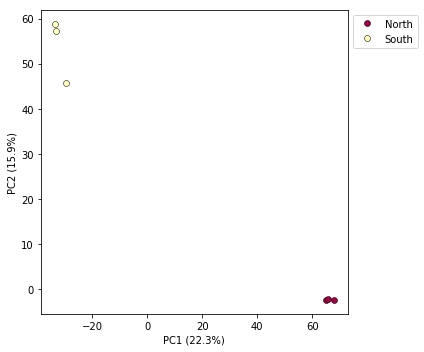

In [29]:
import ipyrad.analysis as ipa
pops_dict = {
     "South":[u'1A_0', u'1B_0', u'1C_0'],
     "North":[u'3J_0', u'3K_0', u'3L_0']
}
vcffile = "/tmp/ipyrad-test/rad_outfiles/rad.vcf"
## Create the pca object
pca = ipa.pca(vcffile, pops_dict)
pca.samples_vcforder
pca.plot()
pca.pcs